# ML Pipeline Preparation
Follow the instructions below to help you create your ML pipeline.
### 1. Import libraries and load data from database.
- Import Python libraries
- Load dataset from database with [`read_sql_table`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_sql_table.html)
- Define feature and target variables X and Y

In [1]:
# import libraries
import nltk
nltk.download(['punkt', 'wordnet','stopwords'])
!pip install wordcloud
%matplotlib inline
import re
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report
from nltk.corpus import stopwords
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
import seaborn as sns
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from sqlalchemy import create_engine 
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_fscore_support
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
import pickle

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/ygrynechko/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/ygrynechko/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ygrynechko/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
# load data from database
def load_data(db,table):
    '''
    INPUT:
    db - database name
    table - table name 
    OUTPUT:
    df - DF with all the data
    '''
    engine = create_engine('sqlite:///'+db+'.db')
    df = pd.read_sql_table(table, engine)
    return df

df = load_data('Twits','Twits')

df.head()

,id,message,original,genre,related,request,offer,aid_related,medical_help,medical_products,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
0,2,Weather update - a cold front from Cuba that c...,Un front froid se retrouve sur Cuba ce matin. ...,direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,7,Is the Hurricane over or is it not over,Cyclone nan fini osinon li pa fini,direct,1,0,0,1,0,0,...,0,0,1,0,1,0,0,0,0,0
2,8,Looking for someone but no name,"Patnm, di Maryani relem pou li banm nouvel li ...",direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,9,UN reports Leogane 80-90 destroyed. Only Hospi...,UN reports Leogane 80-90 destroyed. Only Hospi...,direct,1,1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
4,12,"says: west side of Haiti, rest of the country ...",facade ouest d Haiti et le reste du pays aujou...,direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### 2. Data exploration
Let's look into data a bit closer before we pick the prediction model

In [8]:
#Create the list of the column names, categories
categories = list(df.columns.values)
categories = categories[4:]
categories

['related',
 'request',
 'offer',
 'aid_related',
 'medical_help',
 'medical_products',
 'search_and_rescue',
 'security',
 'military',
 'water',
 'food',
 'shelter',
 'clothing',
 'money',
 'missing_people',
 'refugees',
 'death',
 'other_aid',
 'infrastructure_related',
 'transport',
 'buildings',
 'electricity',
 'tools',
 'hospitals',
 'shops',
 'aid_centers',
 'other_infrastructure',
 'weather_related',
 'floods',
 'storm',
 'fire',
 'earthquake',
 'cold',
 'other_weather',
 'direct_report']

In [4]:
# Calculating number of comments in each category

counts = []
for category in categories:
    counts.append((category, df[category].sum()))
df_stats = pd.DataFrame(counts, columns=['category', 'number of comments'])
df_stats

,category,number of comments
0,related,19914
1,request,4480
2,offer,119
3,aid_related,10878
4,medical_help,2087
5,medical_products,1314
6,search_and_rescue,724
7,security,471
8,military,860
9,water,1674


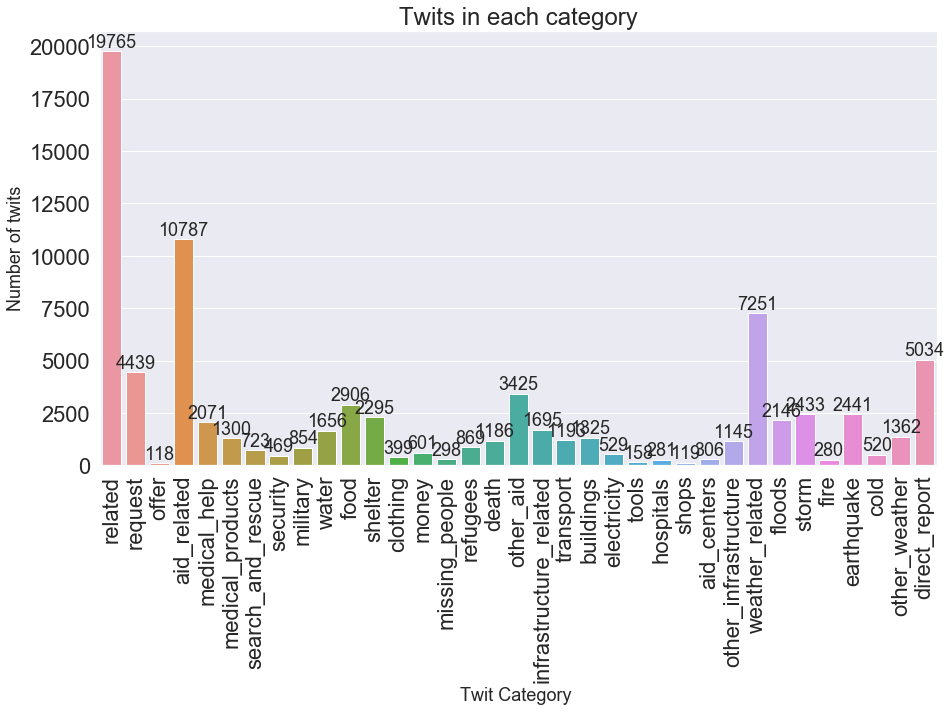

In [9]:
sns.set(font_scale = 2)
plt.figure(figsize=(15,8))
plt.xticks(rotation=90)

ax= sns.barplot(categories, df.iloc[:,4:].sum().values)

plt.title("Twits in each category", fontsize=24)
plt.ylabel('Number of twits', fontsize=18)
plt.xlabel('Twit Category ', fontsize=18)

#adding the text labels
rects = ax.patches
labels = df.iloc[:,4:].sum().values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom', fontsize=18)

plt.show()

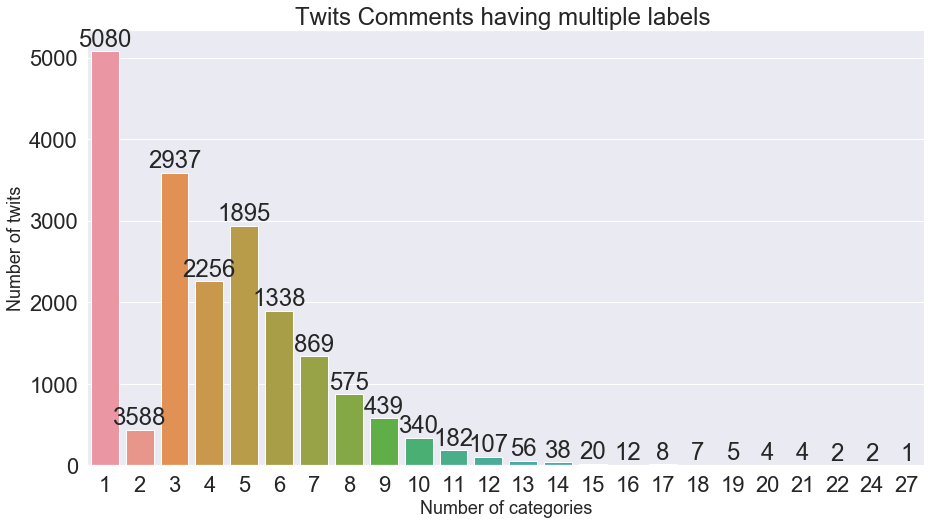

In [10]:
#calculating number of coments in multiple categories
rowSums = df.iloc[:,4:].sum(axis=1)
multiLabel_counts = rowSums.value_counts()
multiLabel_counts = multiLabel_counts.iloc[1:]

sns.set(font_scale = 2)
plt.figure(figsize=(15,8))

ax = sns.barplot(multiLabel_counts.index, multiLabel_counts.values)

plt.title("  ")
plt.ylabel('Number of twits', fontsize=18)
plt.xlabel('Number of categories', fontsize=18)

#adding the text labels
rects = ax.patches
labels = multiLabel_counts.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

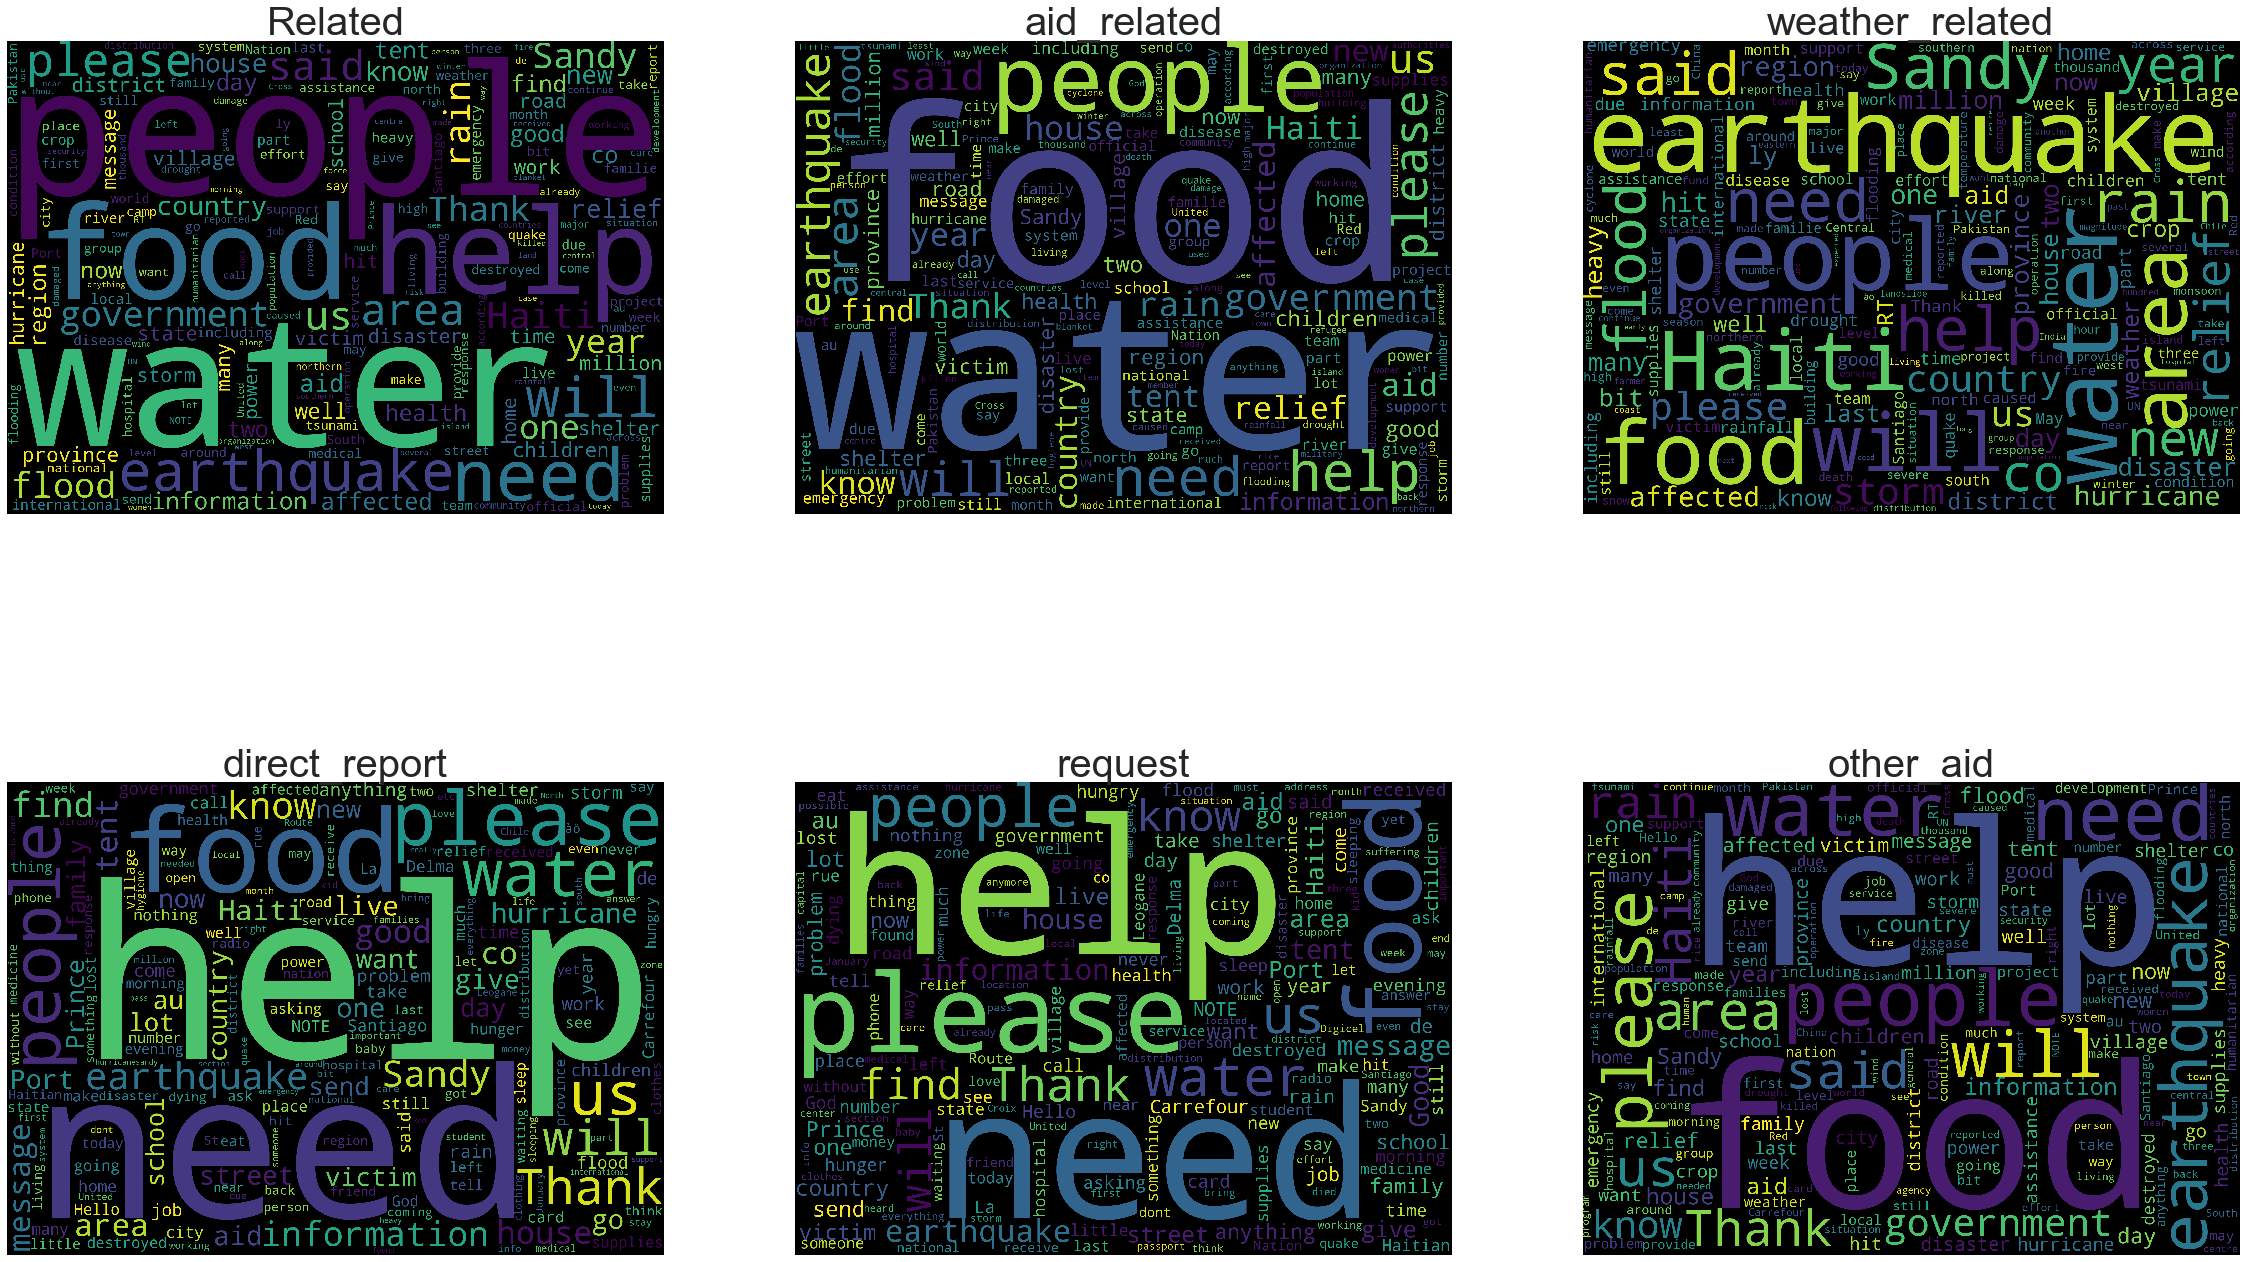

In [7]:
#wordcloud of most used words in top 6 categories
#1-related
#2-aid_related
#3-weather_related
#4-direct_report
#5-request
#6-other_aid
from wordcloud import WordCloud,STOPWORDS



plt.figure(figsize=(40,25))

# related
subset = df[df.related==1]
text = subset.message.str.cat(sep=' ')
cloud_related = WordCloud(
                          stopwords=STOPWORDS,
                          background_color='black',
                          collocations=False,
                          width=2500,
                          height=1800
                         ).generate(text)

plt.subplot(2, 3, 1)
plt.axis('off')
plt.title("Related",fontsize=40)
plt.imshow(cloud_related)


# aid_related
subset = df[df.aid_related==1]
text = subset.message.str.cat(sep=' ')
cloud_aid_related = WordCloud(
                          stopwords=STOPWORDS,
                          background_color='black',
                          collocations=False,
                          width=2500,
                          height=1800
                         ).generate(text)

plt.subplot(2, 3, 2)
plt.axis('off')
plt.title("aid_related",fontsize=40)
plt.imshow(cloud_aid_related)


# weather_related
subset = df[df.weather_related==1]
text = subset.message.str.cat(sep=' ')
cloud_weather_related = WordCloud(
                          stopwords=STOPWORDS,
                          background_color='black',
                          collocations=False,
                          width=2500,
                          height=1800
                         ).generate(text)

plt.subplot(2, 3, 3)
plt.axis('off')
plt.title("weather_related",fontsize=40)
plt.imshow(cloud_weather_related)


# direct_report
subset = df[df.direct_report==1]
text = subset.message.str.cat(sep=' ')
cloud_direct_report = WordCloud(
                          stopwords=STOPWORDS,
                          background_color='black',
                          collocations=False,
                          width=2500,
                          height=1800
                         ).generate(text)

plt.subplot(2, 3, 4)
plt.axis('off')
plt.title("direct_report",fontsize=40)
plt.imshow(cloud_direct_report)


# request
subset = df[df.request==1]
text = subset.message.str.cat(sep=' ')
cloud_request = WordCloud(
                          stopwords=STOPWORDS,
                          background_color='black',
                          collocations=False,
                          width=2500,
                          height=1800
                         ).generate(text)

plt.subplot(2, 3, 5)
plt.axis('off')
plt.title("request",fontsize=40)
plt.imshow(cloud_request)


# other_aid
subset = df[df.other_aid==1]
text = subset.message.str.cat(sep=' ')
cloud_other_aid = WordCloud(
                          stopwords=STOPWORDS,
                          background_color='black',
                          collocations=False,
                          width=2500,
                          height=1800
                         ).generate(text)

plt.subplot(2, 3, 6)
plt.axis('off')
plt.title("other_aid",fontsize=40)
plt.imshow(cloud_other_aid)

plt.show()

### 3. Write a tokenization function to process your text data

In [8]:
#Clean data, remove stop words
def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    return text 
#remove stop words
stop_words = set(stopwords.words('english'))
stop_words.update(['zero','one','two','three','four','five','six','seven','eight','nine','ten','may','also','across','among','beside','however','yet','within'])
re_stop_words = re.compile(r"\b(" + "|".join(stop_words) + ")\\W", re.I)

def removeStopWords(sentence):
    global re_stop_words
    return re_stop_words.sub(" ", sentence)


In [9]:
df['message'] = df['message'].apply(clean_text)
df['message'] = df['message'].apply(removeStopWords)
df.head()

,id,message,original,genre,related,request,offer,aid_related,medical_help,medical_products,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
0,2,weather update cold front cuba could pass ...,Un front froid se retrouve sur Cuba ce matin. ...,direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,7,hurricane over,Cyclone nan fini osinon li pa fini,direct,1,0,0,1,0,0,...,0,0,1,0,1,0,0,0,0,0
2,8,looking someone name,"Patnm, di Maryani relem pou li banm nouvel li ...",direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,9,un reports leogane 80 90 destroyed hospital s...,UN reports Leogane 80-90 destroyed. Only Hospi...,direct,1,1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
4,12,says west side haiti rest country today to...,facade ouest d Haiti et le reste du pays aujou...,direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
def tokenize(text):
    #tokenize text
    
    tokens = word_tokenize(text)
    
    # initiate lemmatizer
    lemmatizer = WordNetLemmatizer()

    # iterate through each token
    clean_tokens = ""
    for token in tokens:
    # tag the word and lemmatize afterwords to try to get the most accurate result. 
        pos_label = (pos_tag(token)[0][1][0]).lower()
        
        if pos_label == 'j': pos_label = 'a'   
            
        if pos_label in ['a', 's', 'v','r']: 
            clean_token = lemmatizer.lemmatize(token, pos=pos_label)
        else:   # For nouns and everything else as it is the default kwarg
            clean_token = lemmatizer.lemmatize(token)
        clean_tokens += clean_token
        clean_tokens += " "
    return clean_tokens
        

In [11]:
#Clean the message column with the use of tokenize function
df['message'] = df['message'].apply(tokenize)
df.head()

,id,message,original,genre,related,request,offer,aid_related,medical_help,medical_products,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
0,2,weather update cold front cuba could pass haiti,Un front froid se retrouve sur Cuba ce matin. ...,direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,7,hurricane over,Cyclone nan fini osinon li pa fini,direct,1,0,0,1,0,0,...,0,0,1,0,1,0,0,0,0,0
2,8,looking someone name,"Patnm, di Maryani relem pou li banm nouvel li ...",direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,9,un report leogane 80 90 destroyed hospital st ...,UN reports Leogane 80-90 destroyed. Only Hospi...,direct,1,1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
4,12,say west side haiti rest country today tonight,facade ouest d Haiti et le reste du pays aujou...,direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### 4. Build a machine learning pipeline
This machine pipeline should take in the `message` column as input and output classification results on the other 36 categories in the dataset. You may find the [MultiOutputClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputClassifier.html) helpful for predicting multiple target variables.

#### Pipeline
scikit-learn provides a Pipeline utility to help automate machine learning workflows. Pipelines are very common in Machine Learning systems, since there is a lot of data to manipulate and many data transformations to apply. So we will utilize pipeline to train every classifier.



In [20]:
# Create pipeline with Classifier
pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', MultiOutputClassifier(RandomForestClassifier()))
    ])

### 5. Train pipeline
- Split data into train and test sets
- Train pipeline

In [21]:
X = df['message']
y = df[df.columns[4:]]

# split data, train and predict
X_train, X_test, y_train, y_test = train_test_split(X, y)


In [25]:
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

### 6. Test your model
Report the f1 score, precision and recall for each output category of the dataset. You can do this by iterating through the columns and calling sklearn's `classification_report` on each.

In [26]:
# Get results and add them to a dataframe.
def get_results(y_test, y_pred):
    results = pd.DataFrame(columns=['Category', 'f_score', 'precision', 'recall'])
    num = 0
    for cat in y_test.columns:
        precision, recall, f_score, support = precision_recall_fscore_support(y_test[cat], y_pred[:,num], average='weighted')
        results.at[num+1, 'Category'] =cat
        results.at[num+1, 'f_score'] =f_score
        results.at[num+1, 'precision']=precision
        results.at[num+1, 'recall']=recall
        num += 1
    print('Aggregated f_score:', results['f_score'].mean())
    print('Aggregated precision:', results['precision'].mean())
    print('Aggregated recall:', results['recall'].mean())
    return results

In [27]:
results = get_results(y_test, y_pred)
results

Aggregated f_score: 0.8971503736339415
Aggregated precision: 0.8881813830990104
Aggregated recall: 0.9230978738358815


/Users/ygrynechko/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Category,f_score,precision,recall
1,related,0.683638,0.679282,0.759686
2,request,0.760826,0.768815,0.823032
3,offer,0.991935,0.989266,0.994619
4,aid_related,0.517918,0.532724,0.563961
5,medical_help,0.880328,0.852623,0.916667
6,medical_products,0.919102,0.895176,0.944342
7,search_and_rescue,0.956775,0.943306,0.970633
8,security,0.9676,0.957112,0.978321
9,military,0.95107,0.935852,0.96679
10,water,0.898638,0.868882,0.930504


### 7. Improve your model
Use grid search to find better parameters. 

In [28]:
pipeline.get_params()

{'memory': None,
 'steps': [('vect',
   CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                   dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                   lowercase=True, max_df=1.0, max_features=None, min_df=1,
                   ngram_range=(1, 1), preprocessor=None, stop_words=None,
                   strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                   tokenizer=None, vocabulary=None)),
  ('tfidf',
   TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True)),
  ('clf',
   MultiOutputClassifier(estimator=RandomForestClassifier(bootstrap=True,
                                                          ccp_alpha=0.0,
                                                          class_weight=None,
                                                          criterion='gini',
                                                          max_depth=None,
                                                

In [29]:
parameters = {'clf__estimator__max_depth': [10, 50, None],
              'clf__estimator__min_samples_leaf':[2, 5, 10]}

cv = GridSearchCV(pipeline, parameters)

### 8. Test your model
Show the accuracy, precision, and recall of the tuned model.  

Since this project focuses on code quality, process, and  pipelines, there is no minimum performance metric needed to pass. However, make sure to fine tune your models for accuracy, precision and recall to make your project stand out - especially for your portfolio!

In [30]:
cv.fit(X_train, y_train)
y_pred = cv.predict(X_test)
results2 = get_results(y_test, y_pred)
results2

Aggregated f_score: 0.8904409860527761
Aggregated precision: 0.8621448896025596
Aggregated recall: 0.9243542435424356


/Users/ygrynechko/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Category,f_score,precision,recall
1,related,0.668043,0.590752,0.768604
2,request,0.744213,0.678648,0.823801
3,offer,0.991935,0.989266,0.994619
4,aid_related,0.427977,0.338486,0.581796
5,medical_help,0.88129,0.845925,0.919742
6,medical_products,0.920024,0.89527,0.946187
7,search_and_rescue,0.957082,0.943324,0.971248
8,security,0.9676,0.957112,0.978321
9,military,0.951377,0.935872,0.967405
10,water,0.899483,0.868989,0.932196


### 9. Try improving your model further. Here are a few ideas:
* try other machine learning algorithms
* add other features besides the TF-IDF

### Testing other methods


In [11]:
#Split data
train, test = train_test_split(df, random_state=42, test_size=0.33, shuffle=True)

X_train = train.message
X_test = test.message

#### OneVsRest multilabel strategy
The Multi-label algorithm accepts a binary mask over multiple labels. The result for each prediction will be an array of 0s and 1s marking which class labels apply to each row input sample.

#### Naive Bayes
OneVsRest strategy can be used for multilabel learning, where a classifier is used to predict multiple labels for instance. Naive Bayes supports multi-class, but we are in a multi-label scenario, therefore, we wrapp Naive Bayes in the OneVsRestClassifier.

In [12]:
#pipeline
NB_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer()),
                ('clf', OneVsRestClassifier(MultinomialNB(
                    fit_prior=True, class_prior=None))),
            ])

In [222]:
#train model for every category
for category in categories:
    print('... Processing {}'.format(category))
    # train the model using X_dtm & y
    NB_pipeline.fit(X_train, train[category])
    # compute the testing accuracy
    prediction = NB_pipeline.predict(X_test)
    print('Test accuracy is {}'.format(accuracy_score(test[category], prediction)))
    print(classification_report(test[category], prediction))

... Processing related
Test accuracy is 0.7649388468258591
              precision    recall  f1-score   support

           0       0.33      0.00      0.00      2016
           1       0.77      1.00      0.87      6569

    accuracy                           0.76      8585
   macro avg       0.55      0.50      0.43      8585
weighted avg       0.66      0.76      0.66      8585

... Processing request
Test accuracy is 0.827140361094933
              precision    recall  f1-score   support

           0       0.83      1.00      0.91      7106
           1       0.39      0.01      0.01      1479

    accuracy                           0.83      8585
   macro avg       0.61      0.50      0.46      8585
weighted avg       0.75      0.83      0.75      8585

... Processing offer
Test accuracy is 0.9967384973791497
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      8557
           1       0.00      0.00      0.00        28

    accu

/Users/ygrynechko/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test accuracy is 0.5730926033779848
              precision    recall  f1-score   support

           0       0.58      0.92      0.72      4994
           1       0.45      0.09      0.15      3591

    accuracy                           0.57      8585
   macro avg       0.52      0.50      0.43      8585
weighted avg       0.53      0.57      0.48      8585

... Processing medical_help
Test accuracy is 0.9207920792079208
              precision    recall  f1-score   support

           0       0.92      1.00      0.96      7905
           1       0.00      0.00      0.00       680

    accuracy                           0.92      8585
   macro avg       0.46      0.50      0.48      8585
weighted avg       0.85      0.92      0.88      8585

... Processing medical_products


/Users/ygrynechko/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test accuracy is 0.9529411764705882
              precision    recall  f1-score   support

           0       0.95      1.00      0.98      8181
           1       0.00      0.00      0.00       404

    accuracy                           0.95      8585
   macro avg       0.48      0.50      0.49      8585
weighted avg       0.91      0.95      0.93      8585

... Processing search_and_rescue


/Users/ygrynechko/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test accuracy is 0.9715783343040186
              precision    recall  f1-score   support

           0       0.97      1.00      0.99      8341
           1       0.00      0.00      0.00       244

    accuracy                           0.97      8585
   macro avg       0.49      0.50      0.49      8585
weighted avg       0.94      0.97      0.96      8585

... Processing security


/Users/ygrynechko/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test accuracy is 0.9813628421665695
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      8425
           1       0.00      0.00      0.00       160

    accuracy                           0.98      8585
   macro avg       0.49      0.50      0.50      8585
weighted avg       0.96      0.98      0.97      8585

... Processing military


/Users/ygrynechko/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test accuracy is 0.968782760629004
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      8317
           1       0.00      0.00      0.00       268

    accuracy                           0.97      8585
   macro avg       0.48      0.50      0.49      8585
weighted avg       0.94      0.97      0.95      8585

... Processing water


/Users/ygrynechko/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test accuracy is 0.936051252184042
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      8039
           1       0.00      0.00      0.00       546

    accuracy                           0.94      8585
   macro avg       0.47      0.50      0.48      8585
weighted avg       0.88      0.94      0.91      8585

... Processing food
Test accuracy is 0.8882935352358765
              precision    recall  f1-score   support

           0       0.89      1.00      0.94      7626
           1       0.50      0.00      0.00       959

    accuracy                           0.89      8585
   macro avg       0.69      0.50      0.47      8585
weighted avg       0.85      0.89      0.84      8585

... Processing shelter
Test accuracy is 0.9110075713453698
              precision    recall  f1-score   support

           0       0.91      1.00      0.95      7823
           1       0.00      0.00      0.00       762

    accuracy                    

/Users/ygrynechko/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test accuracy is 0.9765870704717531
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      8384
           1       0.00      0.00      0.00       201

    accuracy                           0.98      8585
   macro avg       0.49      0.50      0.49      8585
weighted avg       0.95      0.98      0.97      8585

... Processing missing_people


/Users/ygrynechko/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test accuracy is 0.9895165987186954
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      8495
           1       0.00      0.00      0.00        90

    accuracy                           0.99      8585
   macro avg       0.49      0.50      0.50      8585
weighted avg       0.98      0.99      0.98      8585

... Processing refugees


/Users/ygrynechko/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test accuracy is 0.9665695981362842
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      8298
           1       0.00      0.00      0.00       287

    accuracy                           0.97      8585
   macro avg       0.48      0.50      0.49      8585
weighted avg       0.93      0.97      0.95      8585

... Processing death


/Users/ygrynechko/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test accuracy is 0.9531741409435062
              precision    recall  f1-score   support

           0       0.95      1.00      0.98      8183
           1       0.00      0.00      0.00       402

    accuracy                           0.95      8585
   macro avg       0.48      0.50      0.49      8585
weighted avg       0.91      0.95      0.93      8585

... Processing other_aid


/Users/ygrynechko/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test accuracy is 0.8668608037274316
              precision    recall  f1-score   support

           0       0.87      1.00      0.93      7443
           1       0.00      0.00      0.00      1142

    accuracy                           0.87      8585
   macro avg       0.43      0.50      0.46      8585
weighted avg       0.75      0.87      0.81      8585

... Processing infrastructure_related
Test accuracy is 0.9304601048340128
              precision    recall  f1-score   support

           0       0.93      1.00      0.96      7988
           1       0.00      0.00      0.00       597

    accuracy                           0.93      8585
   macro avg       0.47      0.50      0.48      8585
weighted avg       0.87      0.93      0.90      8585

... Processing transport


/Users/ygrynechko/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test accuracy is 0.9509609784507863
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      8164
           1       0.00      0.00      0.00       421

    accuracy                           0.95      8585
   macro avg       0.48      0.50      0.49      8585
weighted avg       0.90      0.95      0.93      8585

... Processing buildings


/Users/ygrynechko/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test accuracy is 0.9480489225393127
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      8140
           1       0.00      0.00      0.00       445

    accuracy                           0.95      8585
   macro avg       0.47      0.50      0.49      8585
weighted avg       0.90      0.95      0.92      8585

... Processing electricity
Test accuracy is 0.9811298776936517
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      8423
           1       0.00      0.00      0.00       162

    accuracy                           0.98      8585
   macro avg       0.49      0.50      0.50      8585
weighted avg       0.96      0.98      0.97      8585

... Processing tools


/Users/ygrynechko/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test accuracy is 0.994059405940594
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      8534
           1       0.00      0.00      0.00        51

    accuracy                           0.99      8585
   macro avg       0.50      0.50      0.50      8585
weighted avg       0.99      0.99      0.99      8585

... Processing hospitals


/Users/ygrynechko/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test accuracy is 0.988468258590565
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      8486
           1       0.00      0.00      0.00        99

    accuracy                           0.99      8585
   macro avg       0.49      0.50      0.50      8585
weighted avg       0.98      0.99      0.98      8585

... Processing shops


/Users/ygrynechko/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test accuracy is 0.9948747815958067
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      8541
           1       0.00      0.00      0.00        44

    accuracy                           0.99      8585
   macro avg       0.50      0.50      0.50      8585
weighted avg       0.99      0.99      0.99      8585

... Processing aid_centers


/Users/ygrynechko/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test accuracy is 0.9877693651718114
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      8480
           1       0.00      0.00      0.00       105

    accuracy                           0.99      8585
   macro avg       0.49      0.50      0.50      8585
weighted avg       0.98      0.99      0.98      8585

... Processing other_infrastructure


/Users/ygrynechko/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test accuracy is 0.9537565521258008
              precision    recall  f1-score   support

           0       0.95      1.00      0.98      8188
           1       0.00      0.00      0.00       397

    accuracy                           0.95      8585
   macro avg       0.48      0.50      0.49      8585
weighted avg       0.91      0.95      0.93      8585

... Processing weather_related


/Users/ygrynechko/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test accuracy is 0.7248689574839837
              precision    recall  f1-score   support

           0       0.73      0.99      0.84      6148
           1       0.66      0.06      0.11      2437

    accuracy                           0.72      8585
   macro avg       0.69      0.53      0.48      8585
weighted avg       0.71      0.72      0.63      8585

... Processing floods
Test accuracy is 0.9142690739662201
              precision    recall  f1-score   support

           0       0.91      1.00      0.96      7851
           1       0.00      0.00      0.00       734

    accuracy                           0.91      8585
   macro avg       0.46      0.50      0.48      8585
weighted avg       0.84      0.91      0.87      8585

... Processing storm
Test accuracy is 0.9065812463599301
              precision    recall  f1-score   support

           0       0.91      1.00      0.95      7783
           1       0.50      0.00      0.00       802

    accuracy                   

/Users/ygrynechko/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test accuracy is 0.9051834595224229
              precision    recall  f1-score   support

           0       0.91      1.00      0.95      7759
           1       0.80      0.02      0.04       826

    accuracy                           0.91      8585
   macro avg       0.85      0.51      0.49      8585
weighted avg       0.90      0.91      0.86      8585

... Processing cold
Test accuracy is 0.9788002329644729
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      8403
           1       0.00      0.00      0.00       182

    accuracy                           0.98      8585
   macro avg       0.49      0.50      0.49      8585
weighted avg       0.96      0.98      0.97      8585

... Processing other_weather


/Users/ygrynechko/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test accuracy is 0.9485148514851485
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      8143
           1       0.00      0.00      0.00       442

    accuracy                           0.95      8585
   macro avg       0.47      0.50      0.49      8585
weighted avg       0.90      0.95      0.92      8585

... Processing direct_report


/Users/ygrynechko/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test accuracy is 0.8037274315666861
              precision    recall  f1-score   support

           0       0.80      1.00      0.89      6906
           1       0.36      0.00      0.01      1679

    accuracy                           0.80      8585
   macro avg       0.58      0.50      0.45      8585
weighted avg       0.72      0.80      0.72      8585



### Logistic Regression

In [229]:
LogReg_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=1)),
            ])
for category in categories:
    print('... Processing {}'.format(category))
    # train the model using X_dtm & y
    LogReg_pipeline.fit(X_train, train[category])
    # compute the testing accuracy
    prediction = LogReg_pipeline.predict(X_test)
    print('Test accuracy is {}'.format(accuracy_score(test[category], prediction)))
    print(classification_report(test[category], prediction))

... Processing related
Test accuracy is 0.7616773442050088
              precision    recall  f1-score   support

           0       0.38      0.02      0.04      2016
           1       0.77      0.99      0.86      6569

    accuracy                           0.76      8585
   macro avg       0.57      0.51      0.45      8585
weighted avg       0.68      0.76      0.67      8585

... Processing request
Test accuracy is 0.8242283051834596
              precision    recall  f1-score   support

           0       0.84      0.97      0.90      7106
           1       0.46      0.11      0.17      1479

    accuracy                           0.82      8585
   macro avg       0.65      0.54      0.54      8585
weighted avg       0.77      0.82      0.78      8585

... Processing offer
Test accuracy is 0.9967384973791497
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      8557
           1       0.00      0.00      0.00        28

    acc

/Users/ygrynechko/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test accuracy is 0.5658707047175305
              precision    recall  f1-score   support

           0       0.60      0.78      0.68      4994
           1       0.47      0.26      0.34      3591

    accuracy                           0.57      8585
   macro avg       0.53      0.52      0.51      8585
weighted avg       0.54      0.57      0.54      8585

... Processing medical_help
Test accuracy is 0.9207920792079208
              precision    recall  f1-score   support

           0       0.92      1.00      0.96      7905
           1       0.00      0.00      0.00       680

    accuracy                           0.92      8585
   macro avg       0.46      0.50      0.48      8585
weighted avg       0.85      0.92      0.88      8585

... Processing medical_products


/Users/ygrynechko/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test accuracy is 0.9529411764705882
              precision    recall  f1-score   support

           0       0.95      1.00      0.98      8181
           1       0.00      0.00      0.00       404

    accuracy                           0.95      8585
   macro avg       0.48      0.50      0.49      8585
weighted avg       0.91      0.95      0.93      8585

... Processing search_and_rescue


/Users/ygrynechko/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test accuracy is 0.9715783343040186
              precision    recall  f1-score   support

           0       0.97      1.00      0.99      8341
           1       0.00      0.00      0.00       244

    accuracy                           0.97      8585
   macro avg       0.49      0.50      0.49      8585
weighted avg       0.94      0.97      0.96      8585

... Processing security


/Users/ygrynechko/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test accuracy is 0.9813628421665695
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      8425
           1       0.00      0.00      0.00       160

    accuracy                           0.98      8585
   macro avg       0.49      0.50      0.50      8585
weighted avg       0.96      0.98      0.97      8585

... Processing military


/Users/ygrynechko/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test accuracy is 0.968782760629004
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      8317
           1       0.00      0.00      0.00       268

    accuracy                           0.97      8585
   macro avg       0.48      0.50      0.49      8585
weighted avg       0.94      0.97      0.95      8585

... Processing water


/Users/ygrynechko/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test accuracy is 0.9364006988934187
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      8039
           1       0.00      0.00      0.00       546

    accuracy                           0.94      8585
   macro avg       0.47      0.50      0.48      8585
weighted avg       0.88      0.94      0.91      8585

... Processing food


/Users/ygrynechko/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test accuracy is 0.8882935352358765
              precision    recall  f1-score   support

           0       0.89      1.00      0.94      7626
           1       0.50      0.00      0.01       959

    accuracy                           0.89      8585
   macro avg       0.69      0.50      0.47      8585
weighted avg       0.85      0.89      0.84      8585

... Processing shelter
Test accuracy is 0.9112405358182877
              precision    recall  f1-score   support

           0       0.91      1.00      0.95      7823
           1       0.00      0.00      0.00       762

    accuracy                           0.91      8585
   macro avg       0.46      0.50      0.48      8585
weighted avg       0.83      0.91      0.87      8585

... Processing clothing


/Users/ygrynechko/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test accuracy is 0.9856726849155504
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      8462
           1       0.00      0.00      0.00       123

    accuracy                           0.99      8585
   macro avg       0.49      0.50      0.50      8585
weighted avg       0.97      0.99      0.98      8585

... Processing money


/Users/ygrynechko/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test accuracy is 0.9765870704717531
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      8384
           1       0.00      0.00      0.00       201

    accuracy                           0.98      8585
   macro avg       0.49      0.50      0.49      8585
weighted avg       0.95      0.98      0.97      8585

... Processing missing_people


/Users/ygrynechko/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test accuracy is 0.9895165987186954
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      8495
           1       0.00      0.00      0.00        90

    accuracy                           0.99      8585
   macro avg       0.49      0.50      0.50      8585
weighted avg       0.98      0.99      0.98      8585

... Processing refugees


/Users/ygrynechko/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test accuracy is 0.9665695981362842
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      8298
           1       0.00      0.00      0.00       287

    accuracy                           0.97      8585
   macro avg       0.48      0.50      0.49      8585
weighted avg       0.93      0.97      0.95      8585

... Processing death


/Users/ygrynechko/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test accuracy is 0.9531741409435062
              precision    recall  f1-score   support

           0       0.95      1.00      0.98      8183
           1       0.00      0.00      0.00       402

    accuracy                           0.95      8585
   macro avg       0.48      0.50      0.49      8585
weighted avg       0.91      0.95      0.93      8585

... Processing other_aid


/Users/ygrynechko/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test accuracy is 0.8669772859638905
              precision    recall  f1-score   support

           0       0.87      1.00      0.93      7443
           1       0.00      0.00      0.00      1142

    accuracy                           0.87      8585
   macro avg       0.43      0.50      0.46      8585
weighted avg       0.75      0.87      0.81      8585

... Processing infrastructure_related


/Users/ygrynechko/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test accuracy is 0.9304601048340128
              precision    recall  f1-score   support

           0       0.93      1.00      0.96      7988
           1       0.00      0.00      0.00       597

    accuracy                           0.93      8585
   macro avg       0.47      0.50      0.48      8585
weighted avg       0.87      0.93      0.90      8585

... Processing transport


/Users/ygrynechko/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test accuracy is 0.9509609784507863
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      8164
           1       0.00      0.00      0.00       421

    accuracy                           0.95      8585
   macro avg       0.48      0.50      0.49      8585
weighted avg       0.90      0.95      0.93      8585

... Processing buildings


/Users/ygrynechko/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test accuracy is 0.9481654047757717
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      8140
           1       0.00      0.00      0.00       445

    accuracy                           0.95      8585
   macro avg       0.47      0.50      0.49      8585
weighted avg       0.90      0.95      0.92      8585

... Processing electricity


/Users/ygrynechko/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test accuracy is 0.9811298776936517
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      8423
           1       0.00      0.00      0.00       162

    accuracy                           0.98      8585
   macro avg       0.49      0.50      0.50      8585
weighted avg       0.96      0.98      0.97      8585

... Processing tools


/Users/ygrynechko/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test accuracy is 0.994059405940594
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      8534
           1       0.00      0.00      0.00        51

    accuracy                           0.99      8585
   macro avg       0.50      0.50      0.50      8585
weighted avg       0.99      0.99      0.99      8585

... Processing hospitals


/Users/ygrynechko/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test accuracy is 0.988468258590565
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      8486
           1       0.00      0.00      0.00        99

    accuracy                           0.99      8585
   macro avg       0.49      0.50      0.50      8585
weighted avg       0.98      0.99      0.98      8585

... Processing shops


/Users/ygrynechko/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test accuracy is 0.9948747815958067
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      8541
           1       0.00      0.00      0.00        44

    accuracy                           0.99      8585
   macro avg       0.50      0.50      0.50      8585
weighted avg       0.99      0.99      0.99      8585

... Processing aid_centers


/Users/ygrynechko/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test accuracy is 0.9877693651718114
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      8480
           1       0.00      0.00      0.00       105

    accuracy                           0.99      8585
   macro avg       0.49      0.50      0.50      8585
weighted avg       0.98      0.99      0.98      8585

... Processing other_infrastructure


/Users/ygrynechko/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test accuracy is 0.9537565521258008
              precision    recall  f1-score   support

           0       0.95      1.00      0.98      8188
           1       0.00      0.00      0.00       397

    accuracy                           0.95      8585
   macro avg       0.48      0.50      0.49      8585
weighted avg       0.91      0.95      0.93      8585

... Processing weather_related


/Users/ygrynechko/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test accuracy is 0.7343040186371579
              precision    recall  f1-score   support

           0       0.75      0.95      0.84      6148
           1       0.60      0.19      0.29      2437

    accuracy                           0.73      8585
   macro avg       0.67      0.57      0.56      8585
weighted avg       0.71      0.73      0.68      8585

... Processing floods
Test accuracy is 0.914502038439138
              precision    recall  f1-score   support

           0       0.91      1.00      0.96      7851
           1       0.50      0.00      0.00       734

    accuracy                           0.91      8585
   macro avg       0.71      0.50      0.48      8585
weighted avg       0.88      0.91      0.87      8585

... Processing storm
Test accuracy is 0.9079790331974374
              precision    recall  f1-score   support

           0       0.91      0.99      0.95      7783
           1       0.56      0.07      0.13       802

    accuracy                    

/Users/ygrynechko/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test accuracy is 0.9122888759464182
              precision    recall  f1-score   support

           0       0.92      0.99      0.95      7759
           1       0.72      0.14      0.24       826

    accuracy                           0.91      8585
   macro avg       0.82      0.57      0.60      8585
weighted avg       0.90      0.91      0.88      8585

... Processing cold
Test accuracy is 0.9788002329644729
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      8403
           1       0.00      0.00      0.00       182

    accuracy                           0.98      8585
   macro avg       0.49      0.50      0.49      8585
weighted avg       0.96      0.98      0.97      8585

... Processing other_weather


/Users/ygrynechko/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test accuracy is 0.9485148514851485
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      8143
           1       0.00      0.00      0.00       442

    accuracy                           0.95      8585
   macro avg       0.47      0.50      0.49      8585
weighted avg       0.90      0.95      0.92      8585

... Processing direct_report


/Users/ygrynechko/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test accuracy is 0.8017472335468842
              precision    recall  f1-score   support

           0       0.81      0.98      0.89      6906
           1       0.46      0.09      0.15      1679

    accuracy                           0.80      8585
   macro avg       0.64      0.53      0.52      8585
weighted avg       0.75      0.80      0.74      8585



In [225]:
SVC_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', OneVsRestClassifier(LinearSVC(), n_jobs=1)),
            ])

In [230]:
for category in categories:
    print('... Processing {}'.format(category))
    # train the model using X_dtm & y
    SVC_pipeline.fit(X_train, train[category])
    # compute the testing accuracy
    prediction = SVC_pipeline.predict(X_test)
    print('Test accuracy is {}'.format(accuracy_score(test[category], prediction)))
    print(classification_report(test[category], prediction))

... Processing related
Test accuracy is 0.7273150844496215
              precision    recall  f1-score   support

           0       0.31      0.14      0.19      2016
           1       0.77      0.91      0.84      6569

    accuracy                           0.73      8585
   macro avg       0.54      0.52      0.51      8585
weighted avg       0.67      0.73      0.68      8585

... Processing request
Test accuracy is 0.8126965637740244
              precision    recall  f1-score   support

           0       0.85      0.94      0.89      7106
           1       0.41      0.19      0.25      1479

    accuracy                           0.81      8585
   macro avg       0.63      0.56      0.57      8585
weighted avg       0.77      0.81      0.78      8585

... Processing offer
Test accuracy is 0.9966220151426908
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      8557
           1       0.00      0.00      0.00        28

    acc

/Users/ygrynechko/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test accuracy is 0.9659871869539896
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      8298
           1       0.14      0.00      0.01       287

    accuracy                           0.97      8585
   macro avg       0.55      0.50      0.49      8585
weighted avg       0.94      0.97      0.95      8585

... Processing death
Test accuracy is 0.9516598718695399
              precision    recall  f1-score   support

           0       0.95      1.00      0.98      8183
           1       0.12      0.00      0.01       402

    accuracy                           0.95      8585
   macro avg       0.54      0.50      0.49      8585
weighted avg       0.91      0.95      0.93      8585

... Processing other_aid
Test accuracy is 0.8509027373325568
              precision    recall  f1-score   support

           0       0.87      0.98      0.92      7443
           1       0.13      0.02      0.04      1142

    accuracy                

/Users/ygrynechko/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test accuracy is 0.988468258590565
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      8486
           1       0.00      0.00      0.00        99

    accuracy                           0.99      8585
   macro avg       0.49      0.50      0.50      8585
weighted avg       0.98      0.99      0.98      8585

... Processing shops


/Users/ygrynechko/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test accuracy is 0.9948747815958067
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      8541
           1       0.00      0.00      0.00        44

    accuracy                           0.99      8585
   macro avg       0.50      0.50      0.50      8585
weighted avg       0.99      0.99      0.99      8585

... Processing aid_centers


/Users/ygrynechko/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test accuracy is 0.9876528829353524
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      8480
           1       0.00      0.00      0.00       105

    accuracy                           0.99      8585
   macro avg       0.49      0.50      0.50      8585
weighted avg       0.98      0.99      0.98      8585

... Processing other_infrastructure
Test accuracy is 0.9525917297612114
              precision    recall  f1-score   support

           0       0.95      1.00      0.98      8188
           1       0.19      0.01      0.01       397

    accuracy                           0.95      8585
   macro avg       0.57      0.50      0.50      8585
weighted avg       0.92      0.95      0.93      8585

... Processing weather_related
Test accuracy is 0.7046010483401282
              precision    recall  f1-score   support

           0       0.76      0.87      0.81      6148
           1       0.47      0.30      0.36      2437

    acc

/Users/ygrynechko/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test accuracy is 0.910658124635993
              precision    recall  f1-score   support

           0       0.92      0.99      0.95      7759
           1       0.63      0.17      0.27       826

    accuracy                           0.91      8585
   macro avg       0.78      0.58      0.61      8585
weighted avg       0.89      0.91      0.89      8585

... Processing cold
Test accuracy is 0.9785672684915551
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      8403
           1       0.00      0.00      0.00       182

    accuracy                           0.98      8585
   macro avg       0.49      0.50      0.49      8585
weighted avg       0.96      0.98      0.97      8585

... Processing other_weather
Test accuracy is 0.9470005824111823
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      8143
           1       0.12      0.00      0.01       442

    accuracy              

### 10. Export your model as a pickle file

In [33]:
pickle.dump(cv, open('model.pkl', 'wb'))

### 11. Use this notebook to complete `train.py`
Use the template file attached in the Resources folder to write a script that runs the steps above to create a database and export a model based on a new dataset specified by the user.